<a href="https://colab.research.google.com/github/piacortes/Clase2/blob/master/Actividad_6_Evaluaci%C3%B3n_de_clasificadores_con_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EI2001: Ciencia de Datos en Astronomía
**Profesores:** Pía Cortés, Daniela Barrientos, Matías Suazo, Matías Mattamala

# Actividad Clase 6 - Validación de clasificadores en Machine Learning
## Separando estrellas de galaxias con los datos de SDSS

**Objetivos:** 
1. Introducción al Machine Learning en Python
2. Librería Scikit Learn
3. Uso de Métodos de clasificacion
4. Preaparacion de datos
5. Creacion de Modelo
6. Clasificación
 
 

Al igual que en la clase anterior, antes de comenzar la actividad instalaremos  [`astroquery`](https://astroquery.readthedocs.io/en/latest/). 

In [0]:
# Al agregar ! convertimos nuestro codigo de python a bash (lenguaje usado en la terminal)
!pip install --pre  --quiet astroquery

    100% |████████████████████████████████| 4.2MB 5.6MB/s 
    100% |████████████████████████████████| 61kB 18.9MB/s 
    100% |████████████████████████████████| 2.3MB 10.9MB/s 
    100% |████████████████████████████████| 102kB 25.9MB/s 


# Preliminares

Para empezar utilizaremos el mismo ejemplo de la clase pasada, en que clasificamos estrellas y galaxias  usando **k-Nearest Neighbors**

Recordemos que en este ejemplo:

- Utilizamos tablas de datos obtenidos de **SDSS**. Los datos fueron obtenidos con **`astroquery`**
- Seleccionamos como atributo la fotometría de la **banda r**, para no tener que lidiar con los otros 454 atributos asociados a cada fuente.
- La fotometría de la banda r consistía en 8 valores, que consideramos como un solo vector de atributos:  `psfMag_r, fiberMag_r, fiber2Mag_r, petroMag_r, devMag_r, expMag_r, modelMag_r, cModelMag_r`
- Las clases que nos interesaba identificar eran **galaxias** (representadas con un 0) o **estrellas** (representadas con un 1).
- Utilizamos el paquete [`Scikit Learn`](https://scikit-learn.org/stable/). Scikit learn requiere que nuestros datos esten en alguna estructura de datos donde las columnas sean los atributos y las filas los objetos. 

## Paso 1: Preprocesamiento de los datos

Antes que todo debemos:
1. Obtener los datos
2. Identificar las clases
3. Seleccionar los atributos
4. Separar los conjntos de entrenamiento y prueba

In [0]:
# Importamos las librerias importantes
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importamos astroquery
from astroquery.sdss import SDSS

# Importamos train_test_split de scikit-learn para separar los conjuntos
from sklearn.model_selection import train_test_split


# Vamos a seleccionar 20000 objetos de los catálogos de SDSS
data = SDSS.query_sql("""SELECT TOP 20000
                      p.psfMag_r, p.fiberMag_r, p.fiber2Mag_r, p.petroMag_r, 
                      p.deVMag_r, p.expMag_r, p.modelMag_r, p.cModelMag_r, 
                      s.class
                      
                      FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
                      
                      WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'QSO'
                      
                      """)

# Cambiamos el formato de la tabla obtenida con astroquery a pandas
data_df = data.to_pandas()

# Identificamos las clases existentes y creamos un mapeo
clases = data_df['class'].unique()
mapa = {}
for clase, i in enumerate(clases):
    mapa[i] = clase
    
# Separamos en conjunto de atributos en un Dataframe X
X = np.array(data_df.iloc[:,:-1])

# Separamos el conjunto de clases, y reemplazamos los string por un valor numérico
# En este caso la clase galaxia se asocia a un 0, estrellas a un 1
y = np.array(data_df['class'].map(mapa))

# Guardamos la semilla para separar aleatoriamente los datos
rs = 1851

# Separamos el conjunto de entrenamiento y prueba usando scikit-learn y la semilla anterior
# Escogemos un conjunto de entrenamiento del 70% de las muestras y 30% de test
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size = 0.3, random_state = rs)

/usr/local/lib/python3.6/dist-packages/astroquery/sdss/core.py:865: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


## Paso 2: Entrenamiento del modelo de ML

El segundo paso era identificar el tipo de problema para elegir el modelo de ML. Como este es un problema de clasificación, es aprendizaje supervisado, por lo que tenemos un [amplio espectro de modelos](https://scikit-learn.org/stable/supervised_learning.html) disponibles en scikit-learn. La semana pasada usamos un  [_k Nearest Neighbors_](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html), y por ahora mantendremos el mismo.

Debemos recordar que un aspecto importante de este clasificador en particular, era el parámetro **`n_neighbors`**, que influía en la cantidad de vecinos utilizados para determinar a qué clase pertenecía una nueva fuente procesada por el algoritmo. En esta clase realizaremos un análisis más profundo de su influencia y cómo escoger el óptimo para cada problema.



In [0]:
# Importamos K-nearest neighbors de scikit-learn
from sklearn.neighbors import KNeighborsClassifier

# Creamos una variable para el clasificador
knn_clf = KNeighborsClassifier(n_neighbors=25)

#### Ejecutar el entrenamiento
Como vimos, el entrenamiento es lo más sencillo de realizar gracias a las funciones de scikit-learn: __`modelo.fit(atributos, clases)`__

In [0]:
# Entrenamos el clasificador utilizando los atributos y clases esperadas de acuerdo al conjunto de entrenamiento
knn_clf.fit(train_X, train_y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=25, p=2,
           weights='uniform')

##Paso 3: Predicción con el modelo de ML

Las predicciones del modelo se realizan usando datos distintos al conjunto de entrenamiento, en este caso el conjunto de prueba. Para ello lo realizaremos igual que como fue indicado en el meme de la primera clase

In [0]:
# Hacemos la clasificacion del set de prueba
pred_y = knn_clf.predict(test_X)

## Paso 4: Evaluación del modelo - Matriz de Confusión

La semana pasada también vimos que una forma estándar y sencilla de evaluar la precisión de un modelo de aprendizaje supervisado es a través de la Matriz de Confusión. En esta matriz las __columnas__ representan las __predicciones__ hechas para cada clase, mientras que las __filas__ representan las instancias de la clase real. 

Para que la visualización sea más clara, utilizaremos la función que vimos al final de la clase pasada

In [0]:
# Utilizaremos la implementación de scikit-learn de esta matriz
from sklearn.metrics import confusion_matrix

from sklearn.utils.multiclass import unique_labels


# Función para graficar una matriz de confusión enchulada
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          use_perc=True,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Showing percentual values instead of decimal ones is enabled with 
    `use_perc=True` only when `normalize=True`
    """
    if not title:
        if normalize:
            title = 'Matriz de confusion normalizada'
        else:
            title = 'Matriz de confusion, sin normalizacion'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = cm*100 if use_perc else cm
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion, sin normalizacion')

    print(cm)

    fig, ax = plt.subplots(figsize = (8,8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta Real',
           xlabel='Etiqueta Predicha')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", fontsize=15)

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = format(cm[i, j], fmt)
            val = str(val) + ' %' if (use_perc and normalize) else str(val)
            ax.text(j, i, val, fontsize=25,
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
            
    ax.grid(False)
    fig.tight_layout()
    return ax

Matriz de confusion normalizada
[[97.46268657  2.53731343]
 [ 3.68686869 96.31313131]]


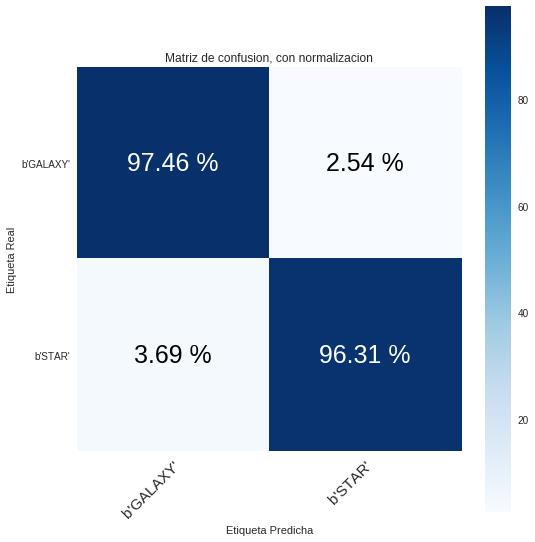

In [0]:
plot_confusion_matrix(test_y, pred_y, classes=clases, normalize = True,
                      title='Matriz de confusion, con normalizacion')

# Validación del modelo: ¿Cómo saber si lo que aprendió está bien?

## Tipos de Errores: Falsos positivos (FP), Verdaderos positivos (TP), Falsos negativos (FN), Verdaderos negativos (TN)

![](https://raw.githubusercontent.com/astrodatos/Clase6/master/Type-I-and-II-errors1-625x468.jpg)

Hay dos tipos de errores:

1. Asignar clase 1 a un objeto que realmente es clase 0: **false positive**

2. Asignar clase 0 a un objeto que realmente es clase 1: **false negative**


![](https://raw.githubusercontent.com/astrodatos/Clase6/master/table.png)

##Métricas: Precision, Recall (True Positive Rate), Accuracy, False Positive Rate

![](https://raw.githubusercontent.com/astrodatos/Clase6/master/Precisionrecall.svg.png)

Primero, vamos a calcular las métricas a mano:

In [0]:
# Obtenemos valores FP, TP, FN y TN de la matriz de confusión
# Consideramos como clase "positiva" el ser galaxia, y "negativa" el ser estrella

cm = confusion_matrix(test_y, pred_y)

# TP
# Número de elementos clasificados correctamente como galaxias
tp = cm[0][0]

# TN
# Número de elementos clasificados correctamente como estrellas
tn = cm[1][1]

# FP
# Número de elementos clasificados como galaxias siendo que eran estrellas
fp = cm[1][0]

# FN
# Número de elementos clasificados como estrellas siendo que eran galaxias
fn = cm[0][1]


# Precision / Capacidad predictiva
# Porcentaje de galaxias clasificadas correctamente en el total de galaxias predichas como tal
precision = tp / (tp + fp)

# Recall / Sensitivity / True Positive Rate
# Porcentaje de galaxias clasificadas correctamente en el total de galaxias que efectivamente lo eran
recall = tp / (tp + fn)

# Accuracy
# Representa el porcentaje total de galaxias y estrellas clasificadas correctamente en el total de elementos
accuracy = (tp + tn) / (tp + fp + tn + fn)

# Printeamos resultados
print('Precision (a mano): ', format(precision, '.3f'))
print('Recall (a mano):    ', format(recall, '.3f'))
print('Accuracy (a mano):  ', format(accuracy, '.3f'))

Precision (a mano):  0.982
Recall (a mano):     0.975
Accuracy (a mano):   0.971


Ahora, usaremos las maravillas de sklearn para calcularlo:

In [0]:
# Ahora con sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score

# Debemos usar las opciones "average='binary'" y  "pos_label=0" para obtener los resultados correctos
precision_sk = precision_score(test_y, pred_y, average='binary', pos_label=0)
recall_sk = recall_score(test_y, pred_y, average='binary', pos_label=0)

accuracy_sk = accuracy_score(test_y, pred_y)

print('Precision (sklearn): ', format(precision_sk, '.3f'))
print('Recall (sklearn):    ', format(recall_sk, '.3f'))
print('Accuracy (sklearn):  ', format(accuracy_sk, '.3f'))


## Validando estadísticamente el modelo


###Cross validation

Consiste en particionar el set de entrenamiento en 2 sub-conjuntos: uno de entrenamiento y otro de prueba. Se realiza varias veces con distintas particiones, con el fin de asegurar que el modelo es independiente del conjunto de entrenamiento.

![](https://raw.githubusercontent.com/astrodatos/Clase6/master/animation_cv.gif)

In [0]:
from sklearn.model_selection import cross_val_score

# Creamos un nuevo clasificador para hacer las pruebas de cross-validation
cv_knn_clf = KNeighborsClassifier(n_neighbors=25)

# Calculamos el puntaje tomando 10 subconjuntos del conjunto de entrenamiento
# Usamos el accuracy como métrica
scores = cross_val_score(cv_knn_clf, train_X, train_y, cv=10, scoring=None)

print('Cross validation promedio: ', format(scores.mean(), '.3f'))
print('Cross validation std:      ', format(scores.std(), '.3f'))

Cross validation promedio:  0.969
Cross validation std:       0.006


## Búsqueda de hiperparámetros
En el ejemplo anterior sempre consideramos el mismo clasificador _k-nearest neighbors_, el cual utilizaba 25 vecinos (`n_neighbors=25`). Sin embargo, ¿cómo podemos saber que elegimos el tamaño correcto?

En esta sección variaremos el numero de vecinos para encontrar el tamaño óptimo. Esto se conoce como **búsqueda de hiperparámetros**, lo que dará paso a distintos modelos con distintos desempeños.


### Iteraciones sobre todo el espacio de parámetros
El caso más directo es iterar sobre una grilla del espacio de parámetros. Para ello, crearemos un vector de N números de vecinos equiespaciados, y entrenaremos el clasificador secuencialmente con cada uno calculando su métrica de cross-validation

In [0]:
# Primer ejemplo, iterando
neighbors = np.arange(1,25,1)
scores = np.zeros(np.shape(neighbors))
stds = np.zeros(np.shape(neighbors))


for s, n in enumerate(neighbors):
  clf = KNeighborsClassifier(n_neighbors=n)
  cv_scores = cross_val_score(clf, train_X, train_y, cv=10, scoring="accuracy")
  scores[s] = cv_scores.mean()
  stds[s] = cv_scores.std()

In [0]:
import matplotlib.pyplot as plt

plt.fill_between(neighbors, scores-stds, scores+stds, alpha=0.3)
plt.plot(neighbors, scores)
plt.xlabel('Número de vecinos')
plt.ylabel('Puntaje de Cross-Validation')
plt.title('Puntaje en función del número de vecinos')

## Overfitting versus Underfitting

Si el modelo representa nuestros datos de forma **muy precisa** (Overfitting), podría no ser generalizable a datos nuevos.

Al contrario, si el modelo no es capaz de captar la estructura de los datos, entonces observaremos Underfitting.

### Bias
Cuantifica la precisión del modelo a través de los sets de entrenamiento.

### Variance 
Cuantifica que tan sensible es el modelo a pequeñas variaciones en el set de entrenamiento.

![](https://raw.githubusercontent.com/astrodatos/Clase6/master/biasvariance.png)

![](https://raw.githubusercontent.com/astrodatos/Clase6/master/over_underfitting.png)



In [0]:
from sklearn.svm import SVC

# Creamos un clasificador SVM
svm_clf = SVC()

# Cross validation
scores = cross_val_score(svm_clf, train_X, train_y, cv=10, scoring=None)

print('Cross validation promedio: ', format(scores.mean(), '.3f'))
print('Cross validation std:      ', format(scores.std(), '.3f'))



/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default 

Cross validation promedio:  0.972
Cross validation std:       0.005
